importer données rotten tomatoes

In [1]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim

import preprocesser
import outils
import modules
    
phraseID, sentenceID, sentences, sentiment = outils.load_tsv("../train.tsv")
train_indexes, test_indexes = outils.split_train_test(phraseID)

Module de preprocessing

Fonctions pour la gestion des inputs 

In [2]:
#lang = preprocesser.Preprocesser(sentences)
#lang.normalize()
#lang.addSentences()
#lang.save("preprocessing_IMDB")


lang = preprocesser.Preprocesser({})
lang.load("../../preprocessing_IMDB")

Fonctions pour l'apprentissage

In [10]:
def X(p,g,i,temperature):
    return np.exp((p[i]+g[i])/temperature)

#size parameters
embedding_size = 512
d = 200
dprime = 20
#modules
embedder = nn.Embedding(lang.n_words,embedding_size)
selector = modules.Selector(embedding_size+d)
skim_rnn = modules.RNN(embedding_size,dprime,2)
rnn = modules.RNN(embedding_size,d,2)
#loss criteria and optimizers
criterion = nn.NLLLoss()
test_criterion = nn.L1Loss()
optim_selector = optim.SGD(selector.parameters(), lr=1e-2)
optim_rnn = optim.SGD([{'params':skim_rnn.parameters()},{'params':rnn.parameters()}], lr=1e-2)
#other variables
skimcount,count = 0,0
temperature, gamma = 0.5,0.02
global_losses, accs = [], []
epoch,mod=0,5

for epoch in range(40):
    #training snippet
    for i in train_indexes[:1000]:
        logp_skim = []
        loss, selector_loss= 0,0
        #make the input and the target
        sentence, target = lang.corpus[i], sentiment[i]
        input, target = preprocesser.makeInputTarget(lang,sentence,target)
        input_size = input.size()[0]
        hidden = rnn.initHidden()
        #go through each word
        for word in range(input_size):
            optim_selector.zero_grad(), optim_rnn.zero_grad()
            x = Variable(input[word])
            embedding = embedder(x).view(1,1,-1)
            #go through the selector
            x = torch.cat((embedding, hidden),2).view(1,-1)
            p = selector(x)
            logp_skim.append(p.data[0,1])     #skimming proba, for regularization purposes
            q = torch.multinomial(p.exp())
            choice = int(q.data[0,0])

            if choice == 0:
                #go through the normal RNN
                output, hidden = rnn(embedding, hidden)

            else:
                #go through the skim rnn, which implies 'cutting' the hidden state,
                #running through the neural network, and building the new hidden state.
                h0 = hidden.view(-1)[:dprime]
                output, h0 = skim_rnn(embedding, h0.view(1,1,-1))
                h1 = hidden.view(-1)[dprime:]
                hidden = torch.cat( (h0.view(1,1,-1), h1.view(1,1,-1)), 2)
                skimcount +=1
            count += 1
            
            #compute losses
            loss += criterion(output,target)
            r_word = torch.FloatTensor([outils.r(p, outils.gumbel(), temperature)[0].prod()])
            #selector_loss += p.view(-1)[choice]*Variable(loss.data * r_word)

            
            ####################derivee à la main #########################################
            g = outils.gumbel()
            if choice==0:
                selector_loss += loss.data*( - X(p.view(-1).data,g,0,temperature) / ( (temperature*np.exp(p.view(-1).data[1]))*(X(p.view(-1).data,g,0,temperature) + X(p.view(-1).data,g,1,temperature))) )
            else:
                selector_loss += loss.data*( - X(p.view(-1).data,g,1,temperature) / ( (temperature*np.exp(p.view(-1).data[0]))*(X(p.view(-1).data,g,0,temperature) + X(p.view(-1).data,g,1,temperature))) )
        
        #final losses calculations, backwards, and gradient steps
        selector_loss = Variable(selector_loss) #+ (gamma/input_size) * np.sum(logp_skim)
        loss.backward(retain_graph=True)
        #selector_loss.backward()

        selector.linear.weight.data -= selector_loss.data*1e-2
        optim_rnn.step()
        #optim_selector.step()

        
    if epoch%mod == 0:
        global_losses.append((loss.data[0], selector_loss.data[0]))
        accs.append(accuracy(test_indexes[:50], lang, embedder, selector, rnn, skim_rnn))
        print epoch
        
    epoch += 1
    
    
    '''debug prints
    print '//////////////////'
    test = selector.linear.weight
    
    print skim_rnn.h20.weight
    '''
    
    

0
5
10
15
20
25
30
35


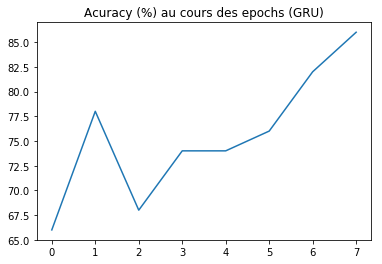

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(accs)
plt.title("Acuracy (%) au cours des epochs (GRU)")

sauvegarder un modèle appris

In [19]:
import pickle as pkl
pkl.dump(embedder,open("models/embedder.p","wb"))
pkl.dump(selector,open("models/selector.p","wb"))
pkl.dump(skim_rnn,open("models/skim_rnn.p","wb"))
pkl.dump(rnn,open("models/rnn.p","wb"))

# TODO

          
- inputs via glove    (// tester différentes tailles d'embedding)


- faire des batchs


- implémenter skim rnn avec option lstm

            DONE


- implémenter fonctions d'évaluations


- hyperparamètrages


- accuracy qui augmente, loss qui diminue, OK; mais sans la régularisation

#TESTS

- Résultats et Temps de Calculs
    - Skip RNN (d=0)

    - RNN de base
    
- IMDB ou AG News


- Visualisation des mots skimmés






Fonction pour l'accuracy

In [9]:
def accuracy(indexes,lang,embedder,selector,rnn,skim_rnn):
    acc = 0.0
    for i in indexes:
        s,t =lang.corpus[i], sentiment[i]
        input,target =  preprocesser.makeInputTarget(lang, s, t)
        input_length = input.size()[0]
        
        for word in range(input_length):
            x, hidden = Variable(input[word]), rnn.initHidden()
            embedding = embedder(x).view(1,1,-1)
            #go through the selector
            x = torch.cat((embedding, hidden),2).view(1,-1)
            p = selector(x)
        
            q = torch.multinomial(p.exp())
            choice = int(q.data[0,0])
        
            if choice == 0:
                #go through the normal RNN
                output, hidden = rnn(embedding, hidden)
        
            else:
                #go through the skim rnn, which implies 'cutting' the hidden state,
                #running through the neural network, and building the new hidden state.
                h0 = hidden.view(-1)[:dprime]
                output, h0 = skim_rnn(embedding, h0.view(1,1,-1))
                h1 = hidden.view(-1)[dprime:]
                hidden = torch.cat( (h0.view(1,1,-1), h1.view(1,1,-1)), 2) 
        if output.exp().multinomial().data[0,0] == target.data[0]:
            acc += 1
            
    return 100*float(acc/len(indexes))

In [6]:
import modules

embedding_size = 512
d = 200
#modules
embedder = nn.Embedding(lang.n_words,embedding_size)
rnn = modules.RNN(embedding_size,d,2,cell='lstm')
#loss criteria and optimizers
criterion = nn.NLLLoss()
optim_rnn = optim.Adam(rnn.parameters(), lr=1e-2)
#other variables
logp = []
global_losses, accs = [], []
epoch,mod=0,1

for epoch in range(10):
    #training snippet
    for i in train_indexes[:20]:
        hidden = rnn.initHidden()
        loss = 0
        #make the input and the target
        sentence, target = lang.corpus[i], sentiment[i]
        input, target = preprocesser.makeInputTarget(lang,sentence,target)
        input_size = input.size()[0]

        #go through each word
        for word in range(input_size):
            optim_rnn.zero_grad()

            x = Variable(input[word])
            embedding = embedder(x).view(1,1,-1)
            output, hidden = rnn(embedding, hidden)
            

        loss = criterion(output,target)
        loss.backward()
        
        optim_rnn.step()

        
    if epoch%mod == 0:
        global_losses.append((loss.data[0]))
        #accs.append(accuracy(test_indexes[:20], lang, embedder, selector, rnn, skim_rnn))
        print epoch
        
    epoch += 1


0
1
2
3
4
5
6
7
8
9


[1.582663655281067,
 0.6272304654121399,
 0.007780063431710005,
 0.002306742127984762,
 0.0012183331418782473,
 0.0008114837110042572,
 0.0006233725580386817,
 0.0004884500522166491,
 0.0003904209879692644,
 0.00033812003675848246]